In [1]:
from profiler.core import *

## 1. Instantiate Engine
* workers : number of processes
* tol     : tolerance for differences when creating training data (set to 0 if data is completely clean)
* eps     : error bound for inverse covariance estimation (since we use conservative calculation when determining minimum sample size, we recommend to set eps <= 0.01)
* embedtxt: if set to true, differentiate b/w textual data and categorical data, and use word embedding for the former

In [57]:
pf = Profiler(workers=2, tol=0, eps=0.05, embedtxt=False)

## 2. Load Data
* name: any name you like
* src: \[FILE; DF; DB (not implemented)\]
* fpath: required if src == FILE
* df: required if src == DF
* check_param: print parameters used for data loading

In [58]:
pf.session.load_data(name='hospital', src=FILE, fpath='data/TECHospital.csv', encoding="latin-1",
                     check_param=True, na_values='not available')

INFO:profiler.utility:[0.008813142776489258] Load Data start

INFO:profiler.dataset:parameters used for data loading:
 {'na_values': 'not available', 'sep': ',', 'header': 'infer', 'dropcol': None, 'dropna': False, 'encoding': 'latin-1', 'normalize': True, 'min_categories_for_embedding': 10}
INFO:profiler.dataset:inferred types of attributes: {
    "Provider ID": "numeric",
    "Hospital Name": "text",
    "Address": "text",
    "City": "text",
    "State": "text",
    "ZIP Code": "numeric",
    "County Name": "text",
    "Phone Number": "numeric",
    "Condition": "categorical",
    "Measure ID": "text",
    "Measure Name": "text",
    "Score": "text",
    "Sample": "text",
    "Footnote": "text",
    "Measure Start Date": "categorical",
    "Measure End Date": "categorical"
}
INFO:profiler.dataset:(possible types: numeric, categorical, text, date)
INFO:profiler.dataset:inferred operators of attributes: {'Provider ID': ['equal'], 'Hospital Name': ['equal'], 'Address': ['equal'], 'City

### 2.1 Change Data Types of Attributes
* required input:
    * a list of attributes
    * a list of data types (must match the order of the attributes; can be CATEGORICAL, NUMERIC, TEXT, DATE)
* optional input:
    * a list of regular expression extractor

In [59]:
pf.session.change_dtypes(['Provider ID', 'Phone Number', 'Score', 'Sample', 'Measure Start Date', 'Measure End Date'], 
                            [CATEGORICAL, CATEGORICAL, NUMERIC, NUMERIC, DATE, DATE])

INFO:profiler.dataset:updated types of Provider ID to 'categorical'
INFO:profiler.dataset:updated operators of Provider ID to ['equal']
INFO:profiler.dataset:updated types of Phone Number to 'categorical'
INFO:profiler.dataset:updated operators of Phone Number to ['equal']
INFO:profiler.dataset:updated types of Score to 'numeric'
INFO:profiler.dataset:updated operators of Score to ['equal']
INFO:profiler.dataset:updated types of Sample to 'numeric'
INFO:profiler.dataset:updated operators of Sample to ['equal']
INFO:profiler.dataset:updated operators of Measure Start Date to ['equal']
INFO:profiler.dataset:updated operators of Measure End Date to ['equal']
INFO:profiler.dataset:updated inferred operators of attributes: {'Provider ID': ['equal'], 'Hospital Name': ['equal'], 'Address': ['equal'], 'City': ['equal'], 'State': ['equal'], 'ZIP Code': ['equal'], 'County Name': ['equal'], 'Phone Number': ['equal'], 'Condition': ['equal'], 'Measure ID': ['equal'], 'Measure Name': ['equal'], 'Sco

### 2.2. Load/Train Embeddings for TEXT
* path: path to saved/to-save embedding folder
* load: set to true -- load saved vec from 'path'; set to false -- train locally
* save: (only for load = False) save trained vectors to 'path'

## 3. Load Training Data
* multiplier: if set to None, will infer the minimal sample size; otherwise, it will create (# samples) * (# attributes) * (multiplier) training samples

In [60]:
pf.session.load_training_data(multiplier = None)

INFO:profiler.utility:[14.765315055847168] Create Training Data start

INFO:profiler.transformer:needs multiplier = 2 to bound the error in inv cov estimation <= 0.05000000
INFO:profiler.transformer:use multiplier = 2, and the bound is 0.00005616
INFO:profiler.transformer:Draw Pairs
100%|██████████| 16/16 [00:02<00:00,  7.30it/s]
INFO:profiler.transformer:Number of training samples: 1614816
INFO:profiler.transformer:Computing Differences
INFO:profiler.transformer:estimated missing data probability in training data is 0.0855
INFO:profiler.utility:[25.311820030212402] Create Training Data execution time: 10.546504974365234



## 4. Learn Structure
* sparsity: intensity of L1-regularizer in inverse covariance estimation (glasso)
* take_neg: if set to true, consider equal -> equal only

In [137]:
autoregress_matrix = pf.session.learn_structure(sparsity=0, infer_order=False, threshold=0)

INFO:profiler.utility:[8207.750318050385] Learn Structure start

INFO:profiler.learner:use threshold 0.0000
INFO:profiler.utility:[8207.928231239319] Learn Structure execution time: 0.17791318893432617



* score: 
    * "fit_error": mse for fitting y = B'X + c for each atttribute y 
    * "training_data_fd_vio_ratio": the higher the score, the more violations of FDs in the training data. (bounded: \[0,1\])

In [138]:
parent_sets = pf.session.get_dependencies(score="fit_error")

INFO:profiler.utility:[8211.903044223785] Get Dependencies start



Provider ID -> Hospital Name (0.0029677687295918635)
Provider ID,Hospital Name -> Address (0.0008239565411318117)
Provider ID,Hospital Name,Address -> City (0.01395442397482766)
Provider ID,Hospital Name,Address -> State (0.0738406509869606)
Provider ID,Hospital Name,Address,City -> ZIP Code (0.003942065330094987)
Provider ID,Hospital Name,Address,State,ZIP Code -> County Name (0.03604454929309879)
City,County Name -> Phone Number (0.5955036237213326)
City,County Name -> Condition (3.4420871648602747)
City,County Name,Condition -> Measure ID (0.8829178544482664)
Provider ID,Hospital Name,Address,State,ZIP Code,Phone Number,Measure ID -> Measure Name (0.02385734823654687)
City,County Name,Condition -> Score (0.14291495776373858)
City,County Name,Condition -> Sample (0.13913976851322746)
City,County Name,Condition,Score,Sample -> Footnote (1.3228411397447573)
City,County Name,Condition,Measure ID,Measure Name,Footnote -> Measure Start Date (0.3887358449111929)


INFO:profiler.utility:[8212.618664264679] Get Dependencies execution time: 0.7156200408935547



Provider ID,Hospital Name,Address,ZIP Code,Phone Number,Measure ID,Measure Name,Score,Sample,Measure Start Date -> Measure End Date (0.052360854552243284)


### Evaluate FDs -- Precision

In [139]:
import os, json
def read_fds(path='data/fds', f='TECHospital-hyfd'):
    all_fds = {}
    for line in open(os.path.join(path,f)):
        fd = json.loads(line)
        right = fd[u'dependant']['columnIdentifier']
        left = [l[u'columnIdentifier'] for l in fd[ u'determinant'][u'columnIdentifiers']]
        if right not in all_fds:
            all_fds[right] = set()
        all_fds[right].add(frozenset(left))
    return all_fds

In [140]:
gt = read_fds()

In [141]:
tp = 0
count = 0
for child in parent_sets:
    found = parent_sets[child]
    if len(found) == 0:
        continue
    count += 1
    match = False
    for parent in gt[child]:
        if set(parent).issubset(found):
            tp += 1
            match = True
            break
    if not match:
        print("{} -> {} is not valid".format(found, child))
    
print("Precision: %.4f"%(float(tp) / count))

['City' 'County Name'] -> Phone Number is not valid
['City' 'County Name'] -> Condition is not valid
['City' 'County Name' 'Condition'] -> Measure ID is not valid
['City' 'County Name' 'Condition'] -> Score is not valid
['City' 'County Name' 'Condition'] -> Sample is not valid
['City' 'County Name' 'Condition' 'Score' 'Sample'] -> Footnote is not valid
Precision: 0.6000


### Evaluate FDs -- Recall

In [142]:
def find_ancesters(node, dic):
    a = []
    if node not in dic:
        return a
    for p in dic[node]:
        a.append(p)
        a.extend(find_ancesters(p, dic))
    return a
def ancester_sets(dic):
    ancesters = {}
    for child in dic:
        ancesters[child] = find_ancesters(child, dic)
    return ancesters

In [143]:
ancesters['Hospital Name']

['Provider ID']

In [144]:
def get_neighbors(hm):
    neighbor = {}
    for i in hm:
        neighbor[i] = set(hm.columns.values[hm.loc[i, :] != 0]) - (set([i]))
    return neighbor

In [145]:
neighbor_sets = get_neighbors(pf.session.struct_engine.inv_cov)

In [146]:
count = 0
miss = 0
for child in neighbor_sets:
    found = neighbor_sets[child]
    for parent in gt[child]:
        count += 1
        if not set(parent).issubset(found):
            miss += 1
            print("{} -> {} is not found".format(parent, child))
print("Recall: %.4f"%(1 - float(miss) / count))

Recall: 1.0000


In [147]:
pf.session.trans_engine.training_data.reset_index().groupby(['Measure Name', 'Hospital Name', 'Address', 'Footnote'])['index'].count()

Measure Name  Hospital Name  Address  Footnote
0.0           0.0            0.0      0.0         175325
                                      1.0         146379
                             1.0      0.0            136
                                      1.0             34
              1.0            0.0      0.0           1010
                                      1.0            361
                             1.0      0.0         506658
                                      1.0         495681
1.0           0.0            0.0      0.0         134886
                                      1.0         154215
                             1.0      0.0              9
                                      1.0              3
              1.0            0.0      0.0             55
                                      1.0             64
Name: index, dtype: int64

In [148]:
gt['Footnote']

{frozenset({'Address', 'Hospital Name', 'Measure Name'}),
 frozenset({'Address', 'Hospital Name', 'Measure ID'}),
 frozenset({'Hospital Name', 'Measure ID', 'Phone Number'}),
 frozenset({'Hospital Name', 'Measure ID', 'ZIP Code'}),
 frozenset({'Hospital Name', 'Measure Name', 'Phone Number'}),
 frozenset({'Hospital Name', 'Measure Name', 'ZIP Code'}),
 frozenset({'City', 'Hospital Name', 'Measure Name', 'State'}),
 frozenset({'City', 'Hospital Name', 'Measure ID', 'State'}),
 frozenset({'Measure ID', 'Provider ID'}),
 frozenset({'Measure Name', 'Provider ID'})}

In [149]:
neighbor_sets['Footnote']

{'Address',
 'City',
 'Condition',
 'County Name',
 'Hospital Name',
 'Measure End Date',
 'Measure ID',
 'Measure Name',
 'Measure Start Date',
 'Phone Number',
 'Provider ID',
 'Sample',
 'Score',
 'State',
 'ZIP Code'}

In [150]:
ancesters = ancester_sets(parent_sets)
count = 0
miss = 0
for child in ancesters:
    found = parent_sets[child]
    for parent in gt[child]:
        count += 1
        if not set(parent).issubset(found):
            miss += 1
            print("{} -> {} is not found".format(parent, child))
print("Recall: %.4f"%(1 - float(miss) / count))

frozenset({'Footnote', 'Phone Number', 'Address'}) -> Provider ID is not found
frozenset({'Footnote', 'ZIP Code', 'Address'}) -> Provider ID is not found
frozenset({'Footnote', 'Phone Number', 'ZIP Code'}) -> Provider ID is not found
frozenset({'County Name', 'Footnote', 'Address'}) -> Provider ID is not found
frozenset({'Phone Number', 'Hospital Name'}) -> Provider ID is not found
frozenset({'ZIP Code', 'Hospital Name'}) -> Provider ID is not found
frozenset({'Hospital Name', 'State', 'City'}) -> Provider ID is not found
frozenset({'Hospital Name', 'Address'}) -> Provider ID is not found
frozenset({'Footnote', 'City', 'Address'}) -> Provider ID is not found
frozenset({'Footnote', 'Phone Number', 'Address'}) -> Hospital Name is not found
frozenset({'Footnote', 'ZIP Code', 'Address'}) -> Hospital Name is not found
frozenset({'Footnote', 'Phone Number', 'ZIP Code'}) -> Hospital Name is not found
frozenset({'County Name', 'Footnote', 'Address'}) -> Hospital Name is not found
frozenset({'F

## 5. Visualization

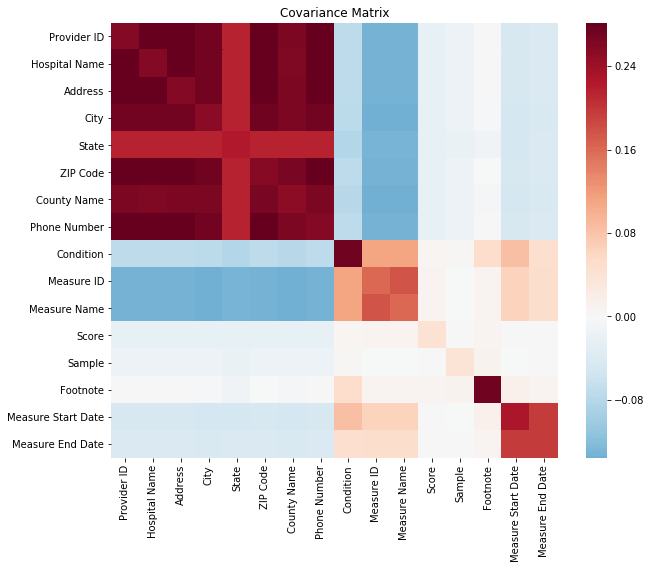

In [151]:
pf.session.visualize_covariance()

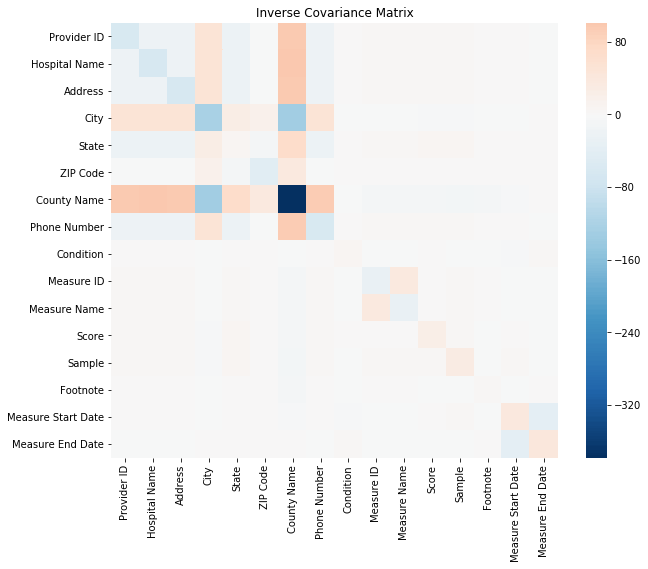

In [152]:
pf.session.visualize_inverse_covariance()

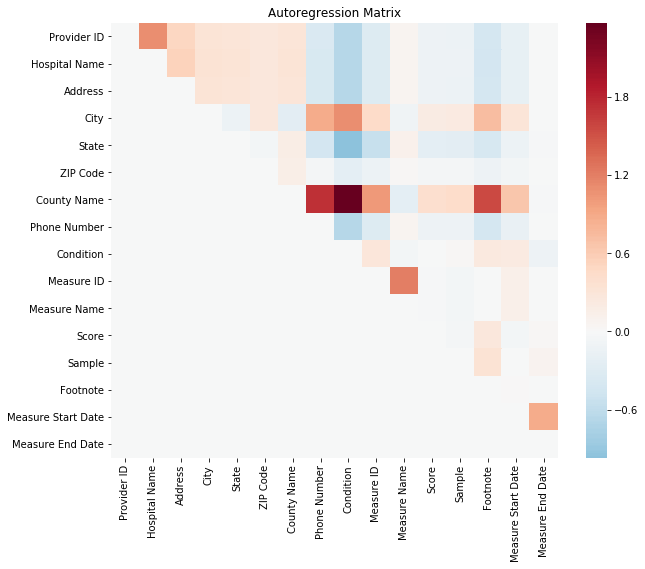

In [153]:
pf.session.visualize_autoregression()

In [11]:
pf.session.timer.get_stat()

,time_point,msg,execution_time
0,0.006949,start: Load Data,0.000000
1,1.052103,end: Load Data,1.045154
2,17.964518,start: Create Training Data,0.000000
3,29.069162,end: Create Training Data,11.104644
4,29.075453,start: Learn Structure,0.000000
5,29.538742,end: Learn Structure,0.463289
6,29.546267,start: Get Dependencies,0.000000
7,30.134318,end: Get Dependencies,0.588051
8,30.134318,total_execution_time,13.201138
